In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchrl
from omegaconf import OmegaConf
from flipper_training.environment.dual_terrain_env import DualTerrainEnv
from flipper_training.configs.terrain_config import TerrainConfig
from flipper_training.configs.robot_config import RobotModelConfig
from flipper_training.configs.engine_config import PhysicsEngineConfig
from flipper_training.utils.torch_utils import set_device
from flipper_training.experiments.ppo.config import PPOExperimentConfig

In [4]:
config = OmegaConf.load("../sota_configs/random_trunk_random_start_goal_sota.yaml")
config = PPOExperimentConfig(**config)

In [5]:
num_robots = 1

In [6]:
from flipper_training.heightmaps.trunks import FixedTrunkHeightmapGenerator
from flipper_training.heightmaps.flat import FlatHeightmapGenerator

# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
trunk_heighmap_gen = FixedTrunkHeightmapGenerator(
    trunk_width=1.0,
    trunk_height=0.3,
)
flat_heighmap_gen = FlatHeightmapGenerator()
trunk_x_grid, trunk_y_grid, trunk_z_grid, trunk_extras = trunk_heighmap_gen(grid_res, max_coord, num_robots, None)
flat_x_grid, flat_y_grid, flat_z_grid, flat_extras = flat_heighmap_gen(grid_res, max_coord, num_robots, None)

In [7]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(trunk_x_grid[0], trunk_y_grid[0], trunk_z_grid[0]).show()
plot_heightmap_3d(flat_x_grid[0], flat_y_grid[0], flat_z_grid[0]).show()

In [8]:
device = "cpu"
device = set_device(device)

In [9]:
# Instatiate the physics config
robot_model = RobotModelConfig(**config.robot_model_opts)
terrain_config_flat = TerrainConfig(
    x_grid=flat_x_grid,
    y_grid=flat_y_grid,
    z_grid=flat_z_grid.clone(),
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=30000,
    grid_extras=flat_extras,
    k_friction_lat=0.5,
    k_friction_lon=1.0,
)
terrain_config_trunk = TerrainConfig(
    x_grid=trunk_x_grid,
    y_grid=trunk_y_grid,
    z_grid=trunk_z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=30000,
    grid_extras=trunk_extras,
    k_friction_lat=0.5,
    k_friction_lon=1.0,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots, **config.engine_opts)

2025-05-06 12:06:24,814 [RobotModelConfig][INFO]: Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_vx0.010_dp384_b512_whl0.02_trck0.05_eaecc2d5466de1eb8911703837d75c759b5c075158ced88ea318e932700dabb2 (robot_config.py:155)


In [10]:
reward_factory = config.reward.make_factory(**config.reward_opts)
obs = [o["cls"].make_factory(**o["opts"]) for o in config.observations]
reward_factory

<function flipper_training.rl_rewards.rewards.PotentialGoal(env: 'Env', goal_reached_reward: float, failed_reward: float, gamma: float, step_penalty: float, potential_coef: float) -> None>

In [11]:
from flipper_training.rl_objectives.fixed_goal import FixedStartGoalNavigation

objective_factory = FixedStartGoalNavigation.make_factory(
    **{
        "start_x_y_z": torch.tensor([-1.0, 0.0, 0.2]),
        "goal_x_y_z": torch.tensor([1.0, 0.0, 0.1]),
        "goal_reached_threshold": 0.1,
        "max_feasible_pitch": torch.deg2rad(torch.tensor(90.0)),
        "max_feasible_roll": torch.deg2rad(torch.tensor(90.0)),
        "iteration_limit": 1500,
        "init_joint_angles": torch.tensor([0.0, 0.0, 0.0, 0.0]),
        "rng": None,
    },
)

In [12]:
env = DualTerrainEnv(
    objective_factory=objective_factory,
    reward_factory=reward_factory,
    observation_factories=obs,
    terrain_config_phys=terrain_config_trunk,
    terrain_config_obs=terrain_config_flat,
    physics_config=physics_config,
    robot_model_config=robot_model,
    device=device,
    differentiable=False,
    batch_size=[num_robots],
    engine_compile_opts=None,
    engine_iters_per_step=config.engine_iters_per_env_step,
    return_derivative=True,
)

env.visualize(mode="phys")
env.visualize(mode="obs")

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                           1 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │    FixedStartGoalNavigation │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

In [13]:
policy_weights_path = "../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/policy_final.pth"
vecnorm_weights_path = "../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/vecnorm_final.pth"

In [14]:
# Load the policy weights
policy_config = config.policy_config(**config.policy_opts)
actor_value_wrapper, optim_groups, policy_transforms = policy_config.create(env, **config.policy_opts, weights_path=policy_weights_path)

2025-05-06 12:06:25,132 [MLPPolicyConfig][INFO]: Applied orthogonal initialization to the actor and value operators. (mlp_policy.py:89)
2025-05-06 12:06:25,139 [MLPPolicyConfig][INFO]: Loaded weights from ../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/policy_final.pth (mlp_policy.py:94)


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

In [15]:
from flipper_training.experiments.ppo.common import make_transformed_env

env, vecnorm = make_transformed_env(env, config, policy_transforms)

vecnorm.load_state_dict(torch.load(vecnorm_weights_path, map_location=device))
env.eval()
actor = actor_value_wrapper.get_policy_operator()
actor.eval()

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/envs/transforms/transforms.py:6500: UserWarning:

VecNorm wasn't initialized and the tensordict is not shared. In single process settings, this is ok, but if you need to share the statistics between workers this should require some attention. Make sure that the content of VecNorm is transmitted to the workers after calling load_state_dict and not before, as other workers may not have access to the loaded TensorDict.



ProbabilisticActor(
    module=ModuleList(
      (0): TensorDictSequential(
          module=ModuleList(
            (0): TensorDictModule(
                module=EncoderCombiner(
                  (encoders): ModuleDict(
                    (LocalStateVector): LocalStateVectorEncoder(
                      (mlp): MLP(
                        (mlp): Sequential(
                          (0): Linear(in_features=15, out_features=64, bias=True)
                          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (2): Tanh()
                          (3): Linear(in_features=64, out_features=64, bias=True)
                          (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (5): Tanh()
                          (6): Linear(in_features=64, out_features=64, bias=True)
                          (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (8): Tanh()
                        

In [16]:
torchrl.envs.utils.check_env_specs(env)

2025-05-06 12:06:25,520 [torchrl][INFO] check_env_specs succeeded!


In [17]:
env.reset(reset_all=True)
env.visualize()

In [18]:
from torchrl.envs.utils import set_exploration_type, ExplorationType

with (
    set_exploration_type(ExplorationType.DETERMINISTIC),
    torch.inference_mode(),
):
    rollout = env.rollout(800, actor, auto_reset=True, break_when_all_done=True)

In [19]:
from simview import SimView
import gc
from flipper_training.engine.engine_state import PhysicsState, PhysicsStateDer
from flipper_training.vis.simview import simview_terrain_from_config, simview_bodies_from_robot_config
from flipper_training.vis.simview import physics_state_to_simview_body_states

simview = SimView(
    run_name="test",
    batch_size=num_robots,
    scalar_names=["cumulative reward", "reward", "terminated", "truncated"],
    dt=env.effective_dt,
    collapse=False,  # display all batches independently
    use_cache=False,
)
simview.model.add_terrain(simview_terrain_from_config(env.terrain_cfg_phys))
for body in simview_bodies_from_robot_config(env.robot_cfg):
    simview.model.add_body(body)
for static_object in env.objective.start_goal_to_simview(env.start, env.goal):
    simview.model.add_static_object(static_object)

# Correct the rewards for robots that have finished the episode
dones = torch.roll(rollout["next", "done"].float(), 1, 1)  # shifted by one timestep forward
dones[:, 0] = 0  # first timestep is not done
reward_key = "raw_reward" if "raw_reward" in rollout["next"] else "reward"
reward_masked = rollout["next", reward_key] * (1 - dones)
reward_masked = reward_masked.squeeze(-1)
cum_reward = torch.cumsum(reward_masked, dim=1)

for i in range(rollout.shape[1]):
    s = PhysicsState.from_tensordict(rollout[DualTerrainEnv.STATE_KEY][:, i])
    ds = (
        PhysicsStateDer.from_tensordict(rollout[DualTerrainEnv.PREV_STATE_DER_KEY][:, i + 1])
        if i < rollout.shape[1] - 1
        else PhysicsStateDer.from_tensordict(rollout[DualTerrainEnv.PREV_STATE_DER_KEY][:, i])
    )
    control = rollout["action"][:, i]
    body_states = physics_state_to_simview_body_states(
        env.robot_cfg,
        s,
        ds,
        control,
    )
    simview.add_state(
        env.effective_dt * i,
        body_states=body_states,
        scalar_values={
            "cumulative reward": cum_reward[:, i].squeeze().tolist(),
            "reward": reward_masked[:, i].squeeze().tolist(),
            "terminated": rollout["next", "terminated"][:, i].int().squeeze().tolist(),
            "truncated": rollout["next", "truncated"][:, i].int().squeeze().tolist(),
        },
    )

if not simview.is_ready:
    raise RuntimeError("SimView is not ready. Check if the model is loaded correctly.")
gc.collect()
simview.visualize()

Saved simulation data to /tmp/.simview_cache/test.json
Preferred port 5420 is not available. Using port 5421 instead.


(24614) wsgi starting up on http://0.0.0.0:5421
(24614) accepted ('127.0.0.1', 50760)
127.0.0.1 - - [06/May/2025 12:06:33] "GET / HTTP/1.1" 200 1869 0.007631
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/css/controls.css HTTP/1.1" 304 210 0.025182
(24614) accepted ('127.0.0.1', 50761)
(24614) accepted ('127.0.0.1', 50762)
(24614) accepted ('127.0.0.1', 50763)
(24614) accepted ('127.0.0.1', 50764)
(24614) accepted ('127.0.0.1', 50765)
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/lib/webm-writer-0.2.0.js HTTP/1.1" 304 220 0.000543
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/lib/tar.js HTTP/1.1" 304 205 0.000468
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/lib/CCapture.js HTTP/1.1" 304 210 0.000253
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/lib/gif.js HTTP/1.1" 304 205 0.001336
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/js/main.js HTTP/1.1" 304 204 0.000324
127.0.0.1 - - [06/May/2025 12:06:34] "GET /static/lib/download.js HTTP/1.1" 304 208 0.000663
127.0.

Client connected


127.0.0.1 - - [06/May/2025 12:07:38] "GET /static/textures/points/ball1.png HTTP/1.1" 304 208 0.000402
127.0.0.1 - - [06/May/2025 12:07:38] "GET /static/textures/contacts/red-cross0.png HTTP/1.1" 304 213 0.000222


Client disconnected


wsgi exiting
127.0.0.1 - - [06/May/2025 12:07:59] "GET /socket.io/?EIO=4&transport=websocket&sid=oTdY2h4NhbwRHmqmAAAA HTTP/1.1" 200 0 20.977279
(24614) wsgi exited, is_accepting=True


tensor[64, 64] n=4096 (16Kb) x∈[-0.366, -0.366] μ=-0.366 σ=9.862e-06


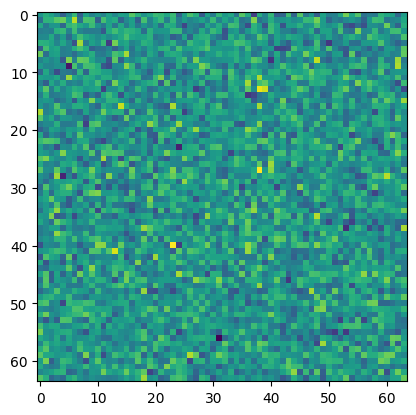

In [20]:
import matplotlib.pyplot as plt

halfway = rollout.shape[1] // 2
im = rollout["Heightmap"][0, halfway].squeeze().cpu()

print(im)
plt.imshow(im)

In [21]:
real_physical_states = rollout[DualTerrainEnv.STATE_KEY]
actions = rollout["action"]
real_physical_states, actions

(TensorDict(
     fields={
         omega: Tensor(shape=torch.Size([1, 163, 3]), device=cpu, dtype=torch.float32, is_shared=False),
         q: Tensor(shape=torch.Size([1, 163, 4]), device=cpu, dtype=torch.float32, is_shared=False),
         thetas: Tensor(shape=torch.Size([1, 163, 4]), device=cpu, dtype=torch.float32, is_shared=False),
         x: Tensor(shape=torch.Size([1, 163, 3]), device=cpu, dtype=torch.float32, is_shared=False),
         xd: Tensor(shape=torch.Size([1, 163, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
     batch_size=torch.Size([1, 163]),
     device=cpu,
     is_shared=False),
 tensor[1, 163, 8] n=1304 (5.1Kb) x∈[-1.162, 1.097] μ=0.207 σ=0.377)

In [22]:
from flipper_training.engine.engine_state import PhysicsState
from tqdm import trange

In [32]:
# Now take the observation terrain, enable the differentiable engine and try to execute the same trajectory
torch.autograd.set_detect_anomaly(True)
n_steps = 50
traj_len = min(real_physical_states.shape[1] - 1, n_steps)
env._set_differentiable(True)
terrain_config_flat.z_grid = torch.nn.Parameter(flat_z_grid.clone(), requires_grad=True)
alpha = 0.1
epochs = 10
max_grad = 0.1
max_height = 0.5
optim = torch.optim.Adam([terrain_config_flat.z_grid], lr=alpha, weight_decay=0.01)
for i in trange(epochs, desc="Epochs", position=1):
    total_loss = 0
    state = PhysicsState.from_tensordict(real_physical_states[:, 0].clone())
    for i in trange(traj_len, desc="Steps", position=0):
        _, state = env._step_engine(state, actions[:, i].clone(), terrain_config_flat)
        actual_state = real_physical_states[:, i + 1].clone()
        estimated_state = state.to_tensordict()
        loss = (estimated_state["x"] - actual_state["x"]).pow(2).mean()
        loss = loss + (estimated_state["xd"] - actual_state["xd"]).pow(2).mean()
        loss = loss + (estimated_state["q"] - actual_state["q"]).pow(2).mean()
        loss = loss + (estimated_state["omega"] - actual_state["omega"]).pow(2).mean()
        total_loss = total_loss + loss
        # loss.backward(retain_graph=True)
        # terrain_config_flat.z_grid = terrain_config_flat.z_grid - alpha * terrain_config_flat.z_grid.grad
        # terrain_config_flat.z_grid.grad = None
        # terrain_config_flat.z_grid.retain_grad()
        # state = state.detach()
        # bar.set_postfix_str(f"{terrain_config_flat.z_grid}")
    total_loss = total_loss / traj_len
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(terrain_config_flat.z_grid, max_grad)
    optim.step()
    optim.zero_grad()
    terrain_config_flat.z_grid.data = torch.clamp(terrain_config_flat.z_grid.data, -max_height, max_height)
    print(f"Epoch {i}: {total_loss}, terrain {terrain_config_flat.z_grid}")

Steps: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


Epoch 49: 0.21483618021011353, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.100, 0.100] μ=-0.000 σ=0.016 grad


Steps: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s]


Epoch 49: 0.18451747298240662, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.167, 0.200] μ=0.000 σ=0.015 grad


Steps: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 49: 0.3874002695083618, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.213, 0.283] μ=0.000 σ=0.016 grad


Steps: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 49: 0.3754711151123047, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.250, 0.346] μ=0.001 σ=0.018 grad


Steps: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s]


Epoch 49: 0.6099054217338562, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.278, 0.432] μ=0.000 σ=0.019 grad


Steps: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Epoch 49: 0.3804539442062378, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.299, 0.450] μ=0.000 σ=0.018 grad


Steps: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Epoch 49: 0.6221184134483337, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.314, 0.489] μ=-7.763e-05 σ=0.018 grad


Steps: 100%|██████████| 50/50 [00:08<00:00,  6.22it/s]


Epoch 49: 0.4381120800971985, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.323, 0.500] μ=-0.000 σ=0.019 grad


Steps: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 49: 0.4849002957344055, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.328, 0.500] μ=-0.000 σ=0.019 grad


Epochs: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]

Epoch 49: 0.49886175990104675, terrain Parameter[1, 128, 128] n=16384 (64Kb) x∈[-0.329, 0.500] μ=-0.000 σ=0.019 grad


In [33]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(
    terrain_config_flat.x_grid[0],
    terrain_config_flat.y_grid[0],
    terrain_config_flat.z_grid[0],
).show()
plot_heightmap_3d(
    terrain_config_trunk.x_grid[0],
    terrain_config_flat.y_grid[0],
    terrain_config_trunk.z_grid[0],
).show()